In [1]:
import importlib
import models
importlib.reload(models)

<module 'models' from 'c:\\Users\\louis\\Desktop\\indicator-forecasting\\models.py'>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from dataset import get_dataloader, plot_statistical_analysis
from torch.utils.data import Subset
import random
from models import load_model_squeezenet, load_model_resnet_18
from model_evaluation.performance import plot_full_evaluation_dashboard
from inference import inference, inference_df
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
from typing import Callable
import sys
from typing import Type

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

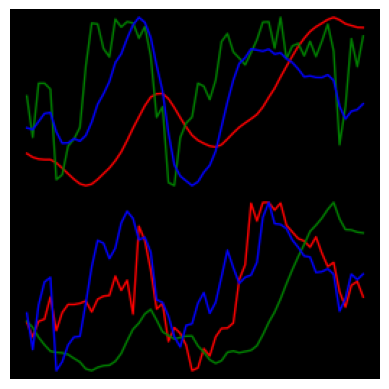

In [4]:
img = mpimg.imread('data_synth\\CAC-40d1_p1_0.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [89]:
TRAIN_DIR = "data/"
TEST_DIR = "test/"
SYNTH_DIR = 'synth/'

LABELS_DIR = "labels"
TRAIN_LABEL_FILE = "train_labels.json"
TEST_LABEL_FILE = "test_labels.json"
SYNTH_LABEL_FILE = "synth_labels.json"
TRAIN_LABEL_PATH = os.path.join(LABELS_DIR, TRAIN_LABEL_FILE)
TEST_LABEL_PATH = os.path.join(LABELS_DIR, TEST_LABEL_FILE)
SYNTH_LABEL_PATH = os.path.join(LABELS_DIR, SYNTH_LABEL_FILE)

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_DIR = 'model'
MODEL_NAME = 'VIT3_72'
MODEL_FILE = MODEL_NAME + '.pth'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

PERF_DIR = 'performances'
PERF_FILE = MODEL_NAME + '.png'
PERF_PATH = os.path.join(PERF_DIR, PERF_FILE)

LOSS_FILE = MODEL_NAME + '_loss.png'
LOSS_PATH = os.path.join(PERF_DIR, LOSS_FILE)

INDICS = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


IMAGE_SIZE = 256

In [86]:
train_loader, train_dataset = get_dataloader(TRAIN_DIR, TRAIN_LABEL_PATH, TRAIN_BATCH_SIZE)#, img_size= IMAGE_SIZE)

test_loader, test_dataset = get_dataloader(TEST_DIR, TEST_LABEL_PATH, TEST_BATCH_SIZE)#, shuffle = False, img_size= IMAGE_SIZE)

test_synth_loader, test_synth_dataset = get_dataloader(SYNTH_DIR, SYNTH_LABEL_PATH, TEST_BATCH_SIZE)#, shuffle = False, img_size= IMAGE_SIZE)

# Create a smaller test subset
subset_size = 1000
assert subset_size <= len(test_dataset), "Subset size exceeds size of test dataset"

# Random sample without replacement
random.seed(3)
indices = random.sample(range(len(test_dataset)), subset_size)

# Wrap in Subset and new DataLoader
small_test_dataset = Subset(test_dataset, indices)
small_test_loader = DataLoader(small_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


indices = random.sample(range(len(test_synth_dataset)), subset_size)


# Wrap in Subset and new DataLoader
small_synth_test_dataset = Subset(test_synth_dataset, indices)
small_synth_test_loader = DataLoader(small_synth_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [87]:
# Accumulate labels
all_labels = []

for _, labels, *_ in tqdm(train_loader):  # *rest handles any extra outputs like dates
    all_labels.append(labels)

# Concatenate into a single tensor
all_labels = torch.cat(all_labels, dim=0)  # shape: [num_samples, num_classes]

# Compute positive and negative counts per class
positive_counts = all_labels.sum(dim=0)
total_counts = all_labels.shape[0]
neg_counts = total_counts - positive_counts

# Compute pos_weight = N / P
pos_weights = neg_counts / positive_counts

# Define loss function with pos_weight
pos_weights = pos_weights.to(torch.float32).to(DEVICE)

print("Positive weights per class:", pos_weights.cpu().numpy())

100%|██████████| 161/161 [00:40<00:00,  3.95it/s]

Positive weights per class: [0.96623176 0.9814385  0.99144965 0.97456646 1.1103789  0.96472394]



📊 Train - Statistical Label Analysis


100%|██████████| 5124/5124 [01:38<00:00, 52.00it/s]


Total samples: 5124


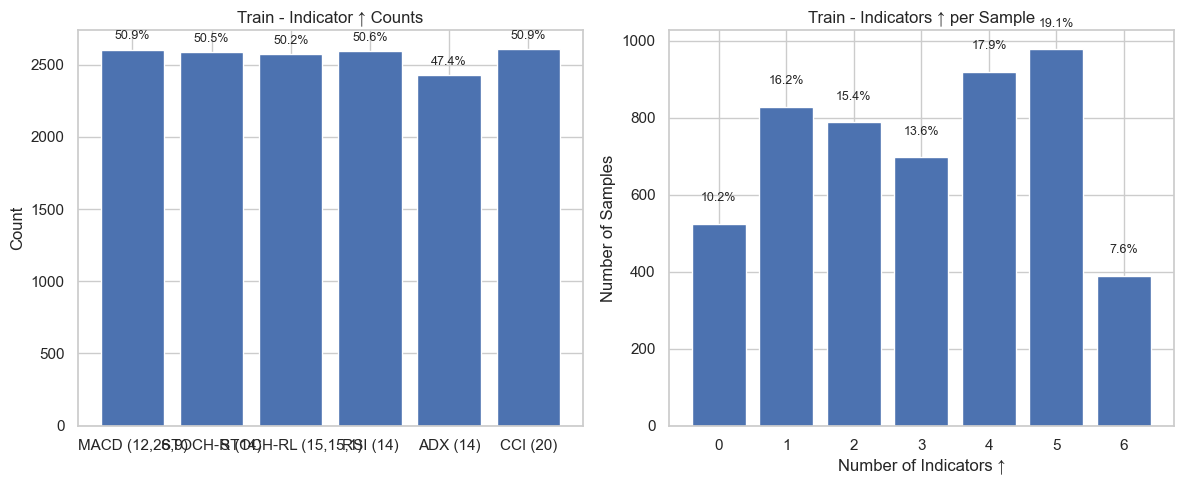

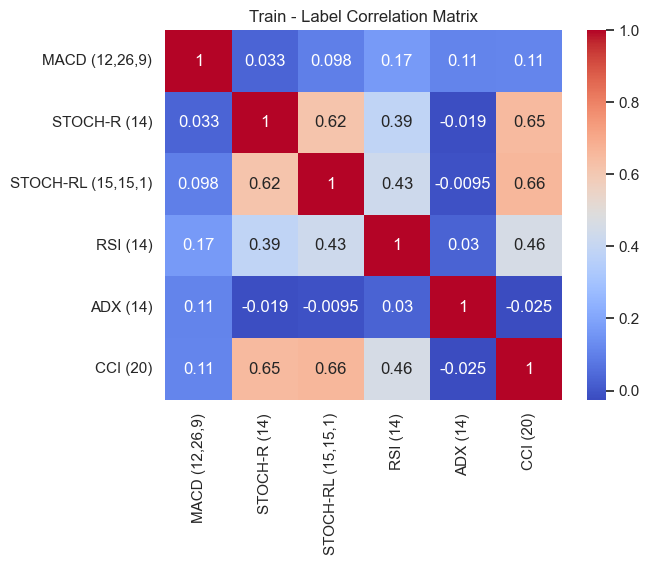


📊 Small Test - Statistical Label Analysis


100%|██████████| 1000/1000 [00:04<00:00, 207.56it/s]


Total samples: 1000


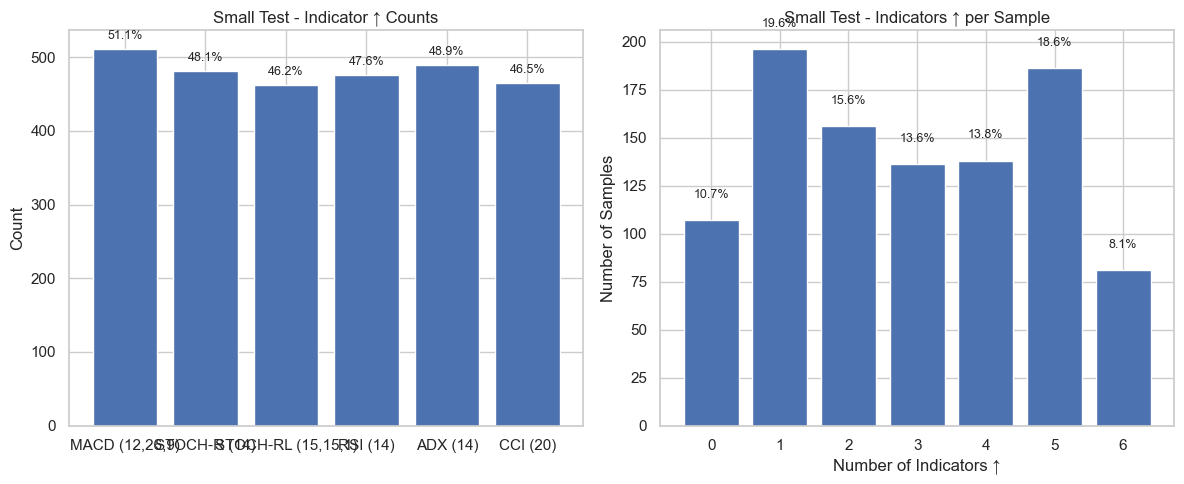

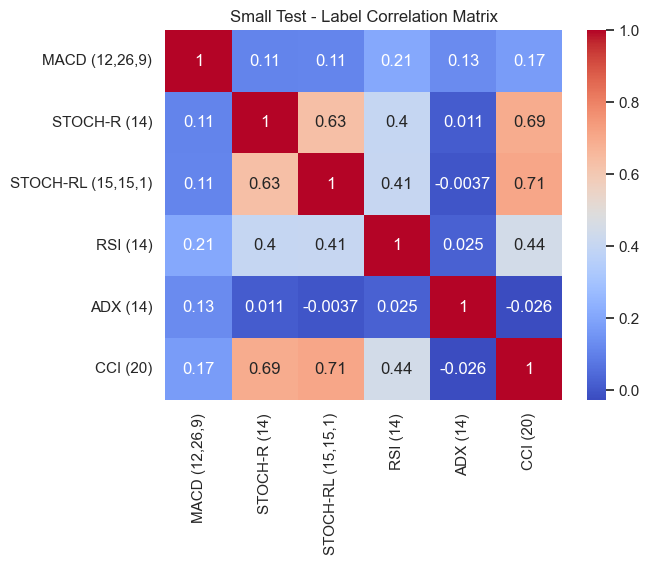


📊 Small Test Synth - Statistical Label Analysis


100%|██████████| 1000/1000 [00:20<00:00, 49.52it/s]


Total samples: 1000


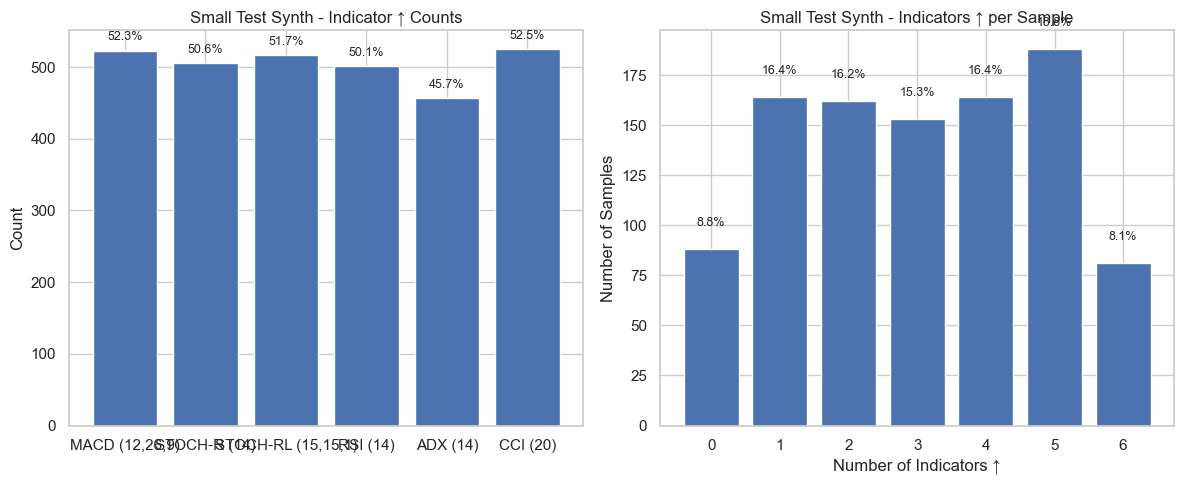

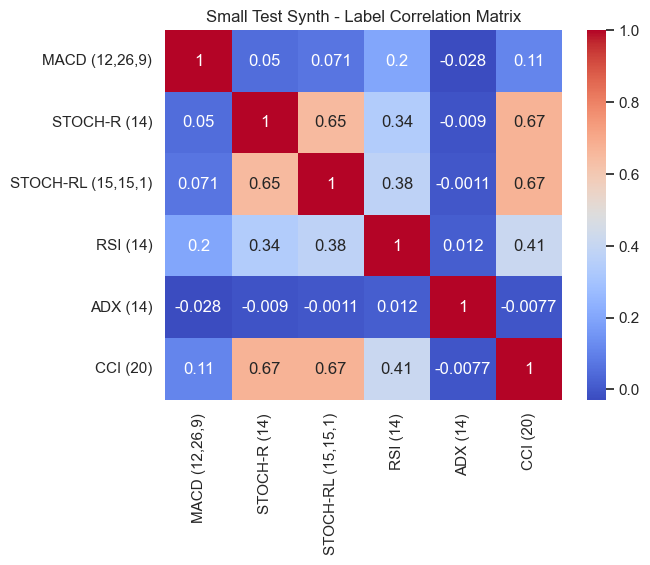

In [50]:
plot_statistical_analysis(train_dataset, INDICS, "Train")
plot_statistical_analysis(small_test_dataset, INDICS, "Small Test")
plot_statistical_analysis(small_synth_test_dataset, INDICS, "Small Test Synth")

## Perf

100%|██████████| 1000/1000 [00:10<00:00, 96.63it/s]
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

Saved to performances\VIT3_72.png


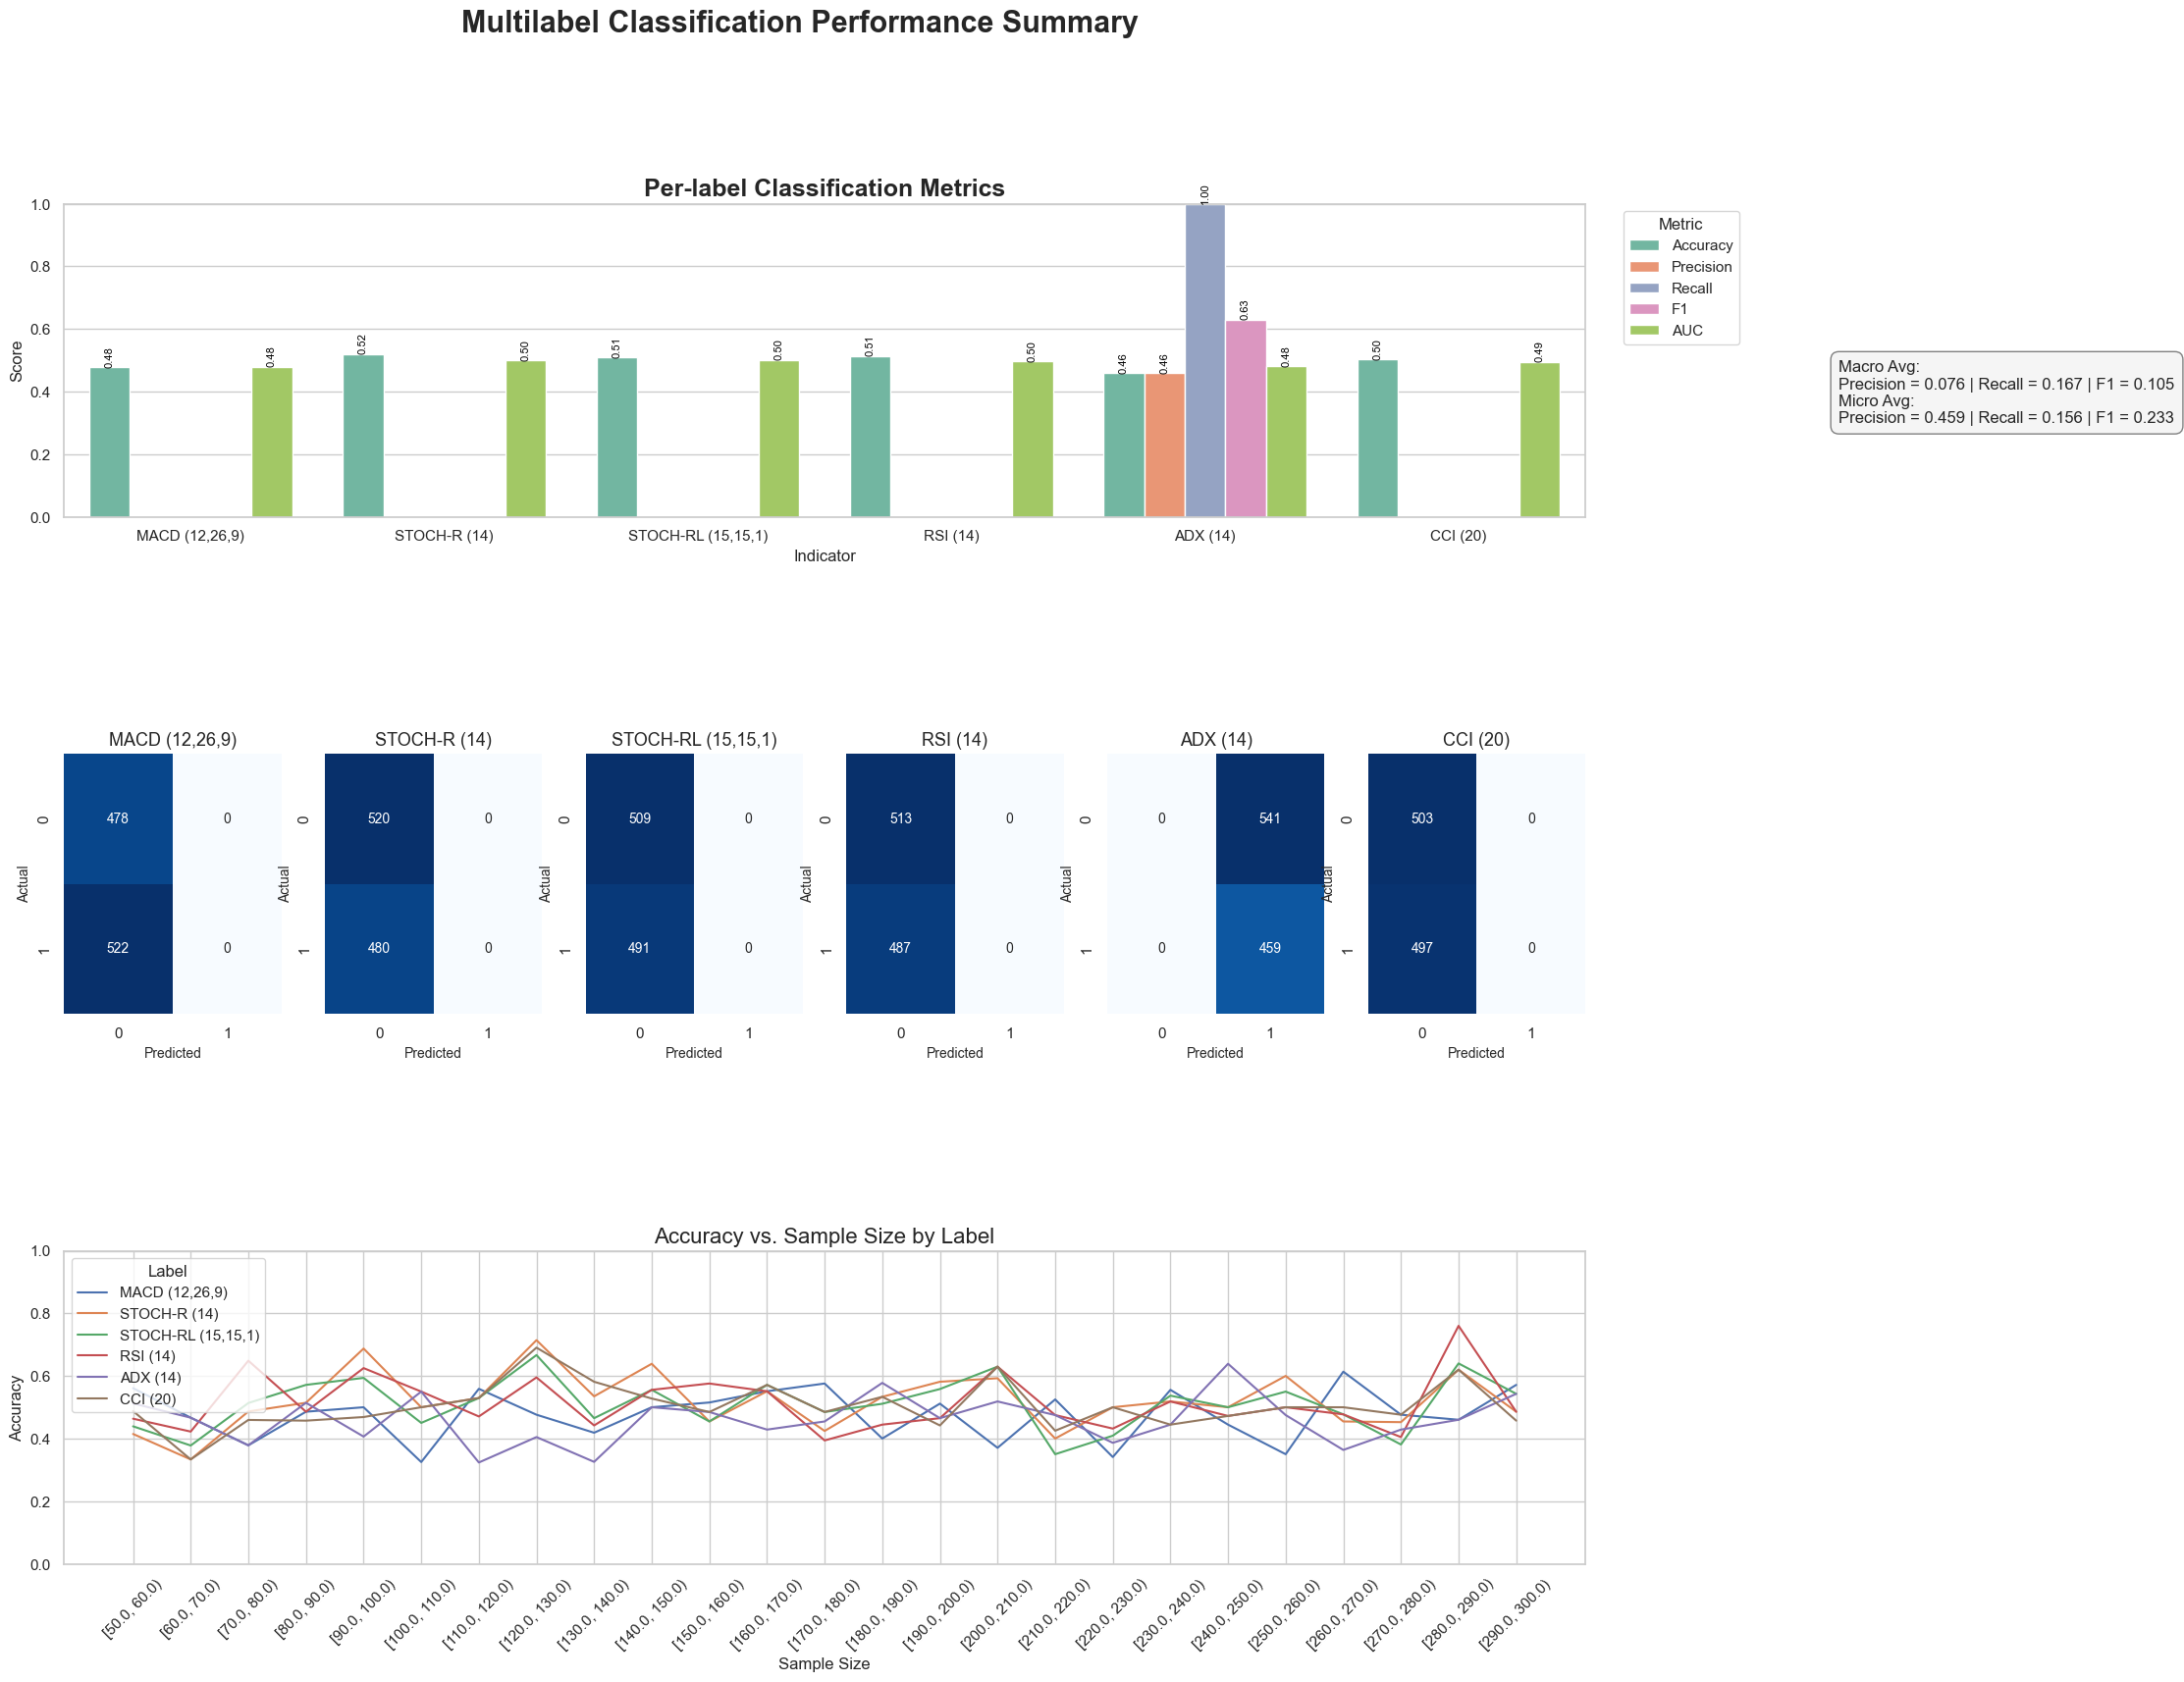

In [79]:
indics = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


#model = load_model_resnet_18(MODEL_PATH, DEVICE)
all_labels, all_preds, all_probs, _, all_lens, _ = inference (model, small_test_loader, INDICS, DEVICE)

plot_full_evaluation_dashboard(all_labels, all_preds, all_probs, all_lens, indics, save_path = PERF_PATH)

In [1]:
def show_predictions(dataset, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples), squeeze=False)

    for i in range(num_samples):
        img, _, _, png_file = dataset[i]
        img_disp = img.permute(1, 2, 0).numpy()  # CHW -> HWC
        img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # denormalize
        img_disp = np.clip(img_disp, 0, 1)

        pred = y_pred[i]
        true = y_true[i]

        title = png_file.split('.')[0]
        ax = axes[i, 0]
        ax.imshow(img_disp)
        ax.axis('off')
        ax.set_title(f"{title} \nTrue: {true.tolist()} | Pred: {pred.tolist()}", fontsize=12)

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()


# Visualize first few predictions
show_predictions(small_test_dataset, all_labels.astype(int), all_preds.astype(int), num_samples=5)


NameError: name 'small_test_dataset' is not defined

## ResNet 1

In [ ]:

EPOCHS = 4
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 6. Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels, _, _ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# 7. Save model
torch.save(model.state_dict(), "model\\resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


## ResNet 2

c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 186/186 [05:35<00:00,  1.80s/it]


Epoch 1/50, Train Loss: 0.7219, Test Loss: 0.7162, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:08<00:00,  1.66s/it]


Epoch 2/50, Train Loss: 0.7095, Test Loss: 0.7068, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:41<00:00,  1.83s/it]


Epoch 3/50, Train Loss: 0.6981, Test Loss: 0.6982, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:17<00:00,  2.03s/it]


Epoch 4/50, Train Loss: 0.6873, Test Loss: 0.6887, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:33<00:00,  1.79s/it]


Epoch 5/50, Train Loss: 0.6757, Test Loss: 0.6791, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:19<00:00,  1.72s/it]


Epoch 6/50, Train Loss: 0.6631, Test Loss: 0.6677, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:25<00:00,  1.75s/it]


Epoch 7/50, Train Loss: 0.6498, Test Loss: 0.6562, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:32<00:00,  1.79s/it]


Epoch 8/50, Train Loss: 0.6373, Test Loss: 0.6446, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:15<00:00,  1.69s/it]


Epoch 9/50, Train Loss: 0.6245, Test Loss: 0.6352, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:15<00:00,  1.69s/it]


Epoch 10/50, Train Loss: 0.6137, Test Loss: 0.6245, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:19<00:00,  1.72s/it]


Epoch 11/50, Train Loss: 0.6028, Test Loss: 0.6174, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:23<00:00,  1.74s/it]


Epoch 12/50, Train Loss: 0.5931, Test Loss: 0.6116, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:27<00:00,  1.76s/it]


Epoch 13/50, Train Loss: 0.5850, Test Loss: 0.6070, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 14/50, Train Loss: 0.5791, Test Loss: 0.6025, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:12<00:00,  2.00s/it]


Epoch 15/50, Train Loss: 0.5712, Test Loss: 0.5992, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 16/50, Train Loss: 0.5667, Test Loss: 0.5967, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:20<00:00,  1.73s/it]


Epoch 17/50, Train Loss: 0.5611, Test Loss: 0.5947, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:39<00:00,  1.82s/it]


Epoch 18/50, Train Loss: 0.5570, Test Loss: 0.5924, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 19/50, Train Loss: 0.5510, Test Loss: 0.5915, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:17<00:00,  1.71s/it]


Epoch 20/50, Train Loss: 0.5483, Test Loss: 0.5905, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:40<00:00,  1.83s/it]


Epoch 21/50, Train Loss: 0.5425, Test Loss: 0.5890, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:22<00:00,  2.06s/it]


Epoch 22/50, Train Loss: 0.5388, Test Loss: 0.5884, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:35<00:00,  1.81s/it]


Epoch 23/50, Train Loss: 0.5349, Test Loss: 0.5881, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:22<00:00,  1.73s/it]


Epoch 24/50, Train Loss: 0.5301, Test Loss: 0.5869, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [05:49<00:00,  1.88s/it]


Epoch 25/50, Train Loss: 0.5255, Test Loss: 0.5872, LR: 0.000001


100%|██████████| 186/186 [06:09<00:00,  1.99s/it]


Epoch 26/50, Train Loss: 0.5211, Test Loss: 0.5859, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:25<00:00,  2.08s/it]


Epoch 27/50, Train Loss: 0.5165, Test Loss: 0.5850, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:10<00:00,  1.99s/it]


Epoch 28/50, Train Loss: 0.5122, Test Loss: 0.5846, LR: 0.000001
Model improved and saved.


100%|██████████| 186/186 [06:13<00:00,  2.01s/it]


Epoch 29/50, Train Loss: 0.5078, Test Loss: 0.5869, LR: 0.000001


100%|██████████| 186/186 [07:09<00:00,  2.31s/it]


Epoch 30/50, Train Loss: 0.5043, Test Loss: 0.5850, LR: 0.000001


100%|██████████| 186/186 [07:34<00:00,  2.44s/it]


Epoch 31/50, Train Loss: 0.4998, Test Loss: 0.5850, LR: 0.000000


100%|██████████| 186/186 [06:37<00:00,  2.14s/it]


Epoch 32/50, Train Loss: 0.4955, Test Loss: 0.5850, LR: 0.000000


100%|██████████| 186/186 [06:27<00:00,  2.08s/it]


Epoch 33/50, Train Loss: 0.4947, Test Loss: 0.5854, LR: 0.000000


100%|██████████| 186/186 [05:14<00:00,  1.69s/it]


Epoch 34/50, Train Loss: 0.4921, Test Loss: 0.5851, LR: 0.000000
Early stopping triggered at epoch 34
Model saved as resnet_multilabel2.pth


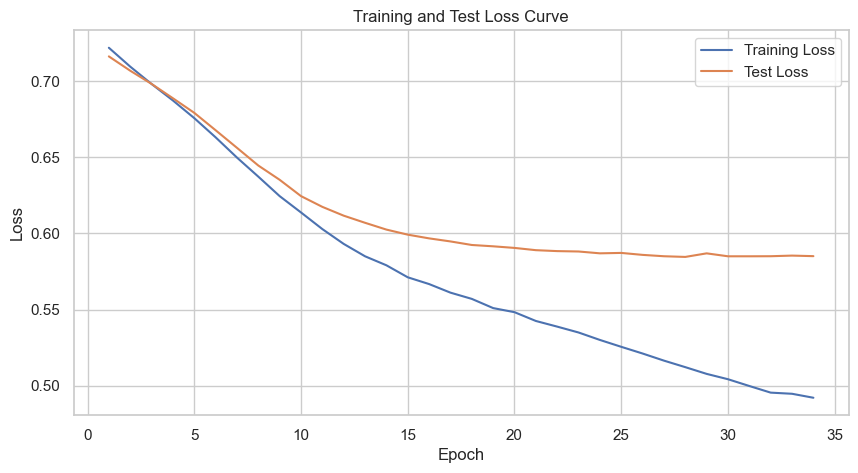

Loss curve saved as performances\resnet_multilabel3_synth_loss.png


In [ ]:
EPOCHS = 50
LR = 1e-6
PATIENCE = 6  # Stop if no improvement after 2 epochs

train_losses = []
test_losses = []
epoch_train_losses =[]
epoch_test_losses =[]


# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6)
)


model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-7
)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    # Training
    model.train()
    running_loss = 0.0

    for images, labels, *_ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        '''if i%20 == 19 :
            train_loss = running_loss / (i*TRAIN_BATCH_SIZE)
            train_losses.append(train_loss)
            
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for images, labels, _, _ in small_test_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * images.size(0)
            test_loss = test_loss / len(small_test_loader.dataset)
            test_losses.append(test_loss)
            
            tqdm.write(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            model.train()'''

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, *_ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    scheduler.step(epoch_test_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, LR: {current_lr:.6f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

torch.save(model.state_dict(), "resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig(LOSS_PATH)
plt.show()

print(f"Loss curve saved as {LOSS_PATH}")

ValueError: x and y must have same first dimension, but have shapes (50,) and (11,)

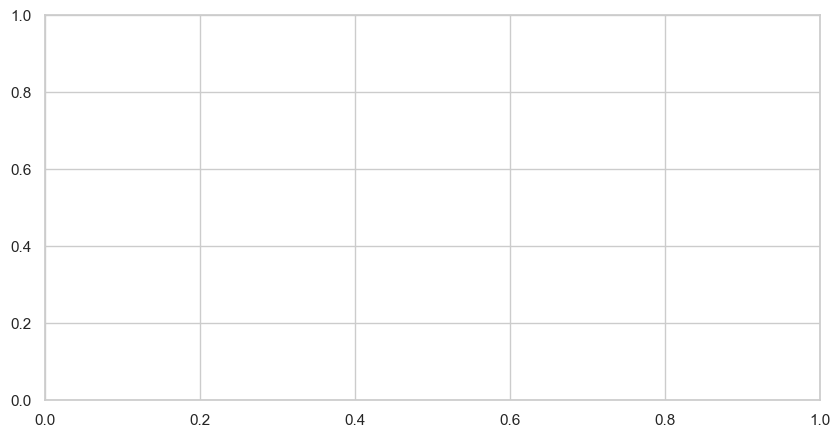

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

print("Loss curve saved as loss_curve.png")

## SqueezeNet 1

c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 186/186 [02:25<00:00,  1.27it/s]


Epoch 1/50, Train Loss: 0.7054, Test Loss: 0.6989, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:25<00:00,  1.28it/s]


Epoch 2/50, Train Loss: 0.6925, Test Loss: 0.6752, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:33<00:00,  1.21it/s]


Epoch 3/50, Train Loss: 0.6625, Test Loss: 0.6623, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:45<00:00,  1.12it/s]


Epoch 4/50, Train Loss: 0.6500, Test Loss: 0.6481, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:29<00:00,  1.24it/s]


Epoch 5/50, Train Loss: 0.6444, Test Loss: 0.6483, LR: 0.000100


100%|██████████| 186/186 [02:27<00:00,  1.26it/s]


Epoch 6/50, Train Loss: 0.6417, Test Loss: 0.6453, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:21<00:00,  1.31it/s]


Epoch 7/50, Train Loss: 0.6377, Test Loss: 0.6422, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:21<00:00,  1.31it/s]


Epoch 8/50, Train Loss: 0.6358, Test Loss: 0.6413, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:18<00:00,  1.34it/s]


Epoch 9/50, Train Loss: 0.6315, Test Loss: 0.6328, LR: 0.000100
Model improved and saved.


100%|██████████| 186/186 [02:20<00:00,  1.33it/s]


Epoch 10/50, Train Loss: 0.6266, Test Loss: 0.6354, LR: 0.000100


100%|██████████| 186/186 [02:26<00:00,  1.27it/s]


Epoch 11/50, Train Loss: 0.6232, Test Loss: 0.6378, LR: 0.000100


100%|██████████| 186/186 [02:19<00:00,  1.34it/s]


Epoch 12/50, Train Loss: 0.6191, Test Loss: 0.6335, LR: 0.000100


100%|██████████| 186/186 [02:20<00:00,  1.32it/s]


Epoch 13/50, Train Loss: 0.6159, Test Loss: 0.6342, LR: 0.000050
Early stopping triggered at epoch 13


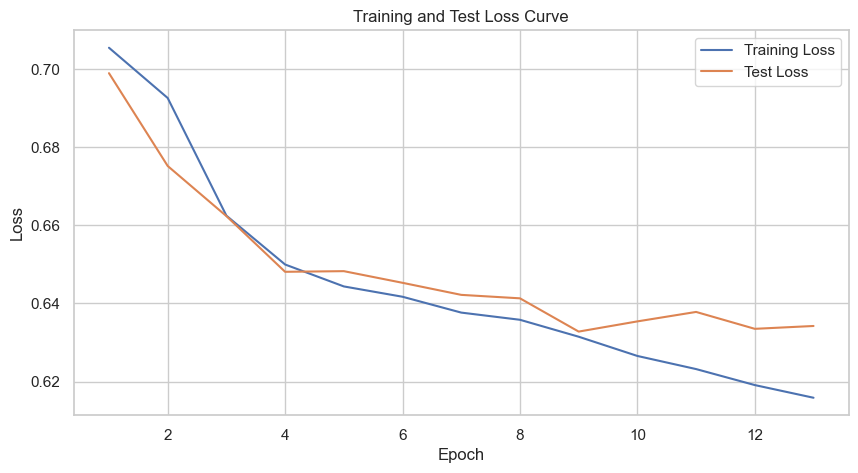

Loss curve saved as loss_curve.png


In [14]:
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4
PATIENCE = 4  # Stop if no improvement after 2 epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_losses = []
test_losses = []

# Load and modify SqueezeNet
base_model = models.squeezenet1_1(pretrained=True)
base_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 6, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    #nn.Sigmoid()
)

class SqueezeNetWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        x = self.base_model(x)
        return x.view(x.size(0), -1)

model = SqueezeNetWrapper(base_model).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    model.train()
    running_loss = 0.0
    for images, labels, *_ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, *_ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    scheduler.step(epoch_test_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, LR: {current_lr:.6f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig(LOSS_PATH)
plt.show()

print("Loss curve saved as loss_curve.png")


## VIT

In [33]:
class CreatePatchesLayer(torch.nn.Module):
  """Custom PyTorch Layer to Extract Patches from Images."""

  def __init__(
    self,
    patch_size: int,
    strides: int,
  ) -> None:
    """Init Variables."""
    super().__init__()
    self.unfold_layer = torch.nn.Unfold(
      kernel_size=patch_size, stride=strides
    )

  def forward(self, images: torch.Tensor) -> torch.Tensor:
    """Forward Pass to Create Patches."""
    patched_images = self.unfold_layer(images)
    return patched_images.permute((0, 2, 1))

In [34]:
class PatchEmbeddingLayer(torch.nn.Module):
  """Positional Embedding Layer for Images of Patches."""

  def __init__(
    self,
    num_patches: int,
    #batch_size: int,
    patch_size: int,
    embed_dim: int,
    device: torch.device,
  ) -> None:
    """Init Function."""
    super().__init__()
    self.num_patches = num_patches
    self.patch_size = patch_size
    self.position_emb = torch.nn.Embedding(
      num_embeddings=num_patches + 1, embedding_dim=embed_dim
    )
    self.projection_layer = torch.nn.Linear(
      patch_size * patch_size * 3, embed_dim
    )
    #self.class_parameter = torch.nn.Parameter(      torch.rand(batch_size, 1, embed_dim).to(device),      requires_grad=True,    )
    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    self.device = device

  def forward(self, patches: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""

    batch_size = patches.size(0)
    positions = (
      torch.arange(start=0, end=self.num_patches + 1, step=1)
      .to(self.device)
      .unsqueeze(dim=0)
    )
    patches = self.projection_layer(patches)
    position_embeddings = self.position_emb(positions)
    encoded_patches = torch.cat(
      (self.class_token.expand(batch_size, -1, -1), patches), dim=1
    ) + position_embeddings.expand(batch_size, -1, -1)
    return encoded_patches

In [35]:
def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    """Create a Feed Forward Network for the Transformer Layer."""
    layer_list = []
    for idx in range(  # pylint: disable=consider-using-enumerate
        len(output_features)
    ):
        if idx == 0:
            linear_layer = torch.nn.Linear(
                in_features=input_features, out_features=output_features[idx]
            )
        else:
            linear_layer = torch.nn.Linear(
                in_features=output_features[idx - 1],
                out_features=output_features[idx],
            )
        dropout = torch.nn.Dropout(p=dropout_rate)
        layers = torch.nn.Sequential(
            linear_layer, activation_function(), dropout
        )
        layer_list.append(layers)
    return torch.nn.Sequential(*layer_list)

In [36]:
class TransformerBlock(torch.nn.Module):
  """Transformer Block Layer."""

  def __init__(
    self,
    num_heads: int,
    key_dim: int,
    embed_dim: int,
    ff_dim: int,
    dropout_rate: float = 0.1,
  ) -> None:
    """Init variables and layers."""
    super().__init__()
    self.layer_norm_input = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.attn = torch.nn.MultiheadAttention(
      embed_dim=embed_dim,
      num_heads=num_heads,
      kdim=key_dim,
      vdim=key_dim,
      batch_first=True,
    )

    self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
    self.layer_norm_1 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.layer_norm_2 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.ffn = create_mlp_block(
      input_features=embed_dim,
      output_features=[ff_dim, embed_dim],
      activation_function=torch.nn.GELU,
      dropout_rate=dropout_rate,
    )

  def forward(self, inputs: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""
    layer_norm_inputs = self.layer_norm_input(inputs)
    attention_output, _ = self.attn(
      query=layer_norm_inputs,
      key=layer_norm_inputs,
      value=layer_norm_inputs,
    )
    attention_output = self.dropout_1(attention_output)
    out1 = self.layer_norm_1(inputs + attention_output)
    ffn_output = self.ffn(out1)
    output = self.layer_norm_2(out1 + ffn_output)
    return output

In [37]:
class ViTMultiLabelClassifierModel(torch.nn.Module):
  """ViT Model for Multi-Label Image Classification."""

  def __init__(
      self,
      num_transformer_layers: int,
      embed_dim: int,
      feed_forward_dim: int,
      num_heads: int,
      patch_size: int,
      num_patches: int,
      mlp_head_units: list[int],
      num_classes: int,
      batch_size: int,
      device: torch.device,
  ) -> None:
      """Init Function."""
      super().__init__()
      self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
      self.patch_embedding_layer = PatchEmbeddingLayer(
          num_patches,  patch_size, embed_dim, device
      )
      self.transformer_layers = torch.nn.ModuleList()
      for _ in range(num_transformer_layers):
          self.transformer_layers.append(
              TransformerBlock(
                  num_heads, embed_dim, embed_dim, feed_forward_dim
              )
          )

      self.mlp_block = create_mlp_block(
          input_features=embed_dim,
          output_features=mlp_head_units,
          activation_function=torch.nn.GELU,
          dropout_rate=0.5,
      )

      self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)
      self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      """Forward Pass."""
      x = self.create_patch_layer(x)
      x = self.patch_embedding_layer(x)
      for transformer_layer in self.transformer_layers:
          x = transformer_layer(x)
      x = x[:, 0]  # CLS token
      x = self.mlp_block(x)
      logits = self.logits_layer(x)
      return self.sigmoid(logits)  # Raw logits for BCEWithLogitsLoss


In [ ]:
def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
  threshold: float = 0.5,
  patience: int = 8,
  lr_decay_factor: float = 0.1,
  min_lr: float = 1e-7
) -> None:
  """Train the Network (Multi-label) with early stopping and LR decay."""
  print("Training Started")

  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=lr_decay_factor, patience=2, min_lr=min_lr
  )
  train_losses = []
  val_losses = []
  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []

    all_train_preds, all_train_labels = [], []
    all_valid_preds, all_valid_labels = [], []

    model.train()
    for x, y, *_ in tqdm(trainloader, desc=f"Epoch {epoch} [Train]"):
      x, y = x.to(device), y.float().to(device)
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      probs = torch.sigmoid(outputs)
      preds = (probs > threshold).int()
      all_train_preds.append(preds.cpu().numpy())
      all_train_labels.append(y.cpu().numpy())

    model.eval()
    with torch.no_grad():
      for x, y, *_ in tqdm(validloader, desc=f"Epoch {epoch} [Valid]"):
        x, y = x.to(device), y.float().to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
        valid_loss.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int()
        all_valid_preds.append(preds.cpu().numpy())
        all_valid_labels.append(y.cpu().numpy())

    # Flatten predictions and labels
    y_train_true = np.vstack(all_train_labels)
    y_train_pred = np.vstack(all_train_preds)
    y_valid_true = np.vstack(all_valid_labels)
    y_valid_pred = np.vstack(all_valid_preds)

    # Metrics
    train_acc = accuracy_score(y_train_true, y_train_pred)
    valid_acc = accuracy_score(y_valid_true, y_valid_pred)
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    valid_f1 = f1_score(y_valid_true, y_valid_pred, average='macro')

    val_loss_mean = np.mean(valid_loss)
    train_loss_mean = np.mean(train_loss)
    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)

    # Learning rate scheduling
    scheduler.step(val_loss_mean)
    current_lr = optimizer.param_groups[0]['lr']

    print(
      f"Epoch {epoch}: "
      f"Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f}, "
      f"Train F1: {train_f1:.4f}, Val F1: {valid_f1:.4f}, "
      f"Learning Rate: {current_lr}"
    )


    # Early stopping check
    if val_loss_mean < best_val_loss:
      best_val_loss = val_loss_mean
      epochs_no_improve = 0
      best_model_state = model.state_dict()  # Save best model
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        model.load_state_dict(best_model_state)  # Restore best model
        break
  torch.save(model.state_dict(), MODEL_PATH)

  # Plotting
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
  plt.plot(range(1, len(val_losses) + 1), val_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Test Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.savefig(LOSS_PATH)
  plt.show()

  print("Loss curve saved as loss_curve.png")


In [71]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
from typing import Callable
import sys
from tqdm import tqdm

def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
  threshold: float = 0.5,
  patience: int = 8,
  lr_decay_factor: float = 0.1,
  min_lr: float = 1e-7
) -> None:
  """Train the Network (Multi-label) with early stopping and LR decay."""
  print("Training Started")

  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=lr_decay_factor, patience=2, min_lr=min_lr
  )

  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []

    all_train_preds, all_train_labels = [], []
    all_valid_preds, all_valid_labels = [], []

    model.train()
    for x, y, *_ in tqdm(trainloader, desc=f"Epoch {epoch} [Train]"):
      x, y = x.to(device), y.float().to(device)
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      probs = torch.sigmoid(outputs)
      preds = (probs > threshold).int()
      all_train_preds.append(preds.cpu().numpy())
      all_train_labels.append(y.cpu().numpy())

    model.eval()
    with torch.no_grad():
      for x, y, *_ in tqdm(validloader, desc=f"Epoch {epoch} [Valid]"):
        x, y = x.to(device), y.float().to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
        valid_loss.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int()
        all_valid_preds.append(preds.cpu().numpy())
        all_valid_labels.append(y.cpu().numpy())

    # Flatten predictions and labels
    y_train_true = np.vstack(all_train_labels)
    y_train_pred = np.vstack(all_train_preds)
    y_valid_true = np.vstack(all_valid_labels)
    y_valid_pred = np.vstack(all_valid_preds)

    # Metrics
    train_acc = accuracy_score(y_train_true, y_train_pred)
    valid_acc = accuracy_score(y_valid_true, y_valid_pred)
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    valid_f1 = f1_score(y_valid_true, y_valid_pred, average='macro')

    val_loss_mean = np.mean(valid_loss)
    train_loss_mean = np.mean(train_loss)

    print(
      f"Epoch {epoch}: "
      f"Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f}, "
      f"Train F1: {train_f1:.4f}, Val F1: {valid_f1:.4f}"
    )

    # Learning rate scheduling
    scheduler.step(val_loss_mean)

    # Early stopping check
    if val_loss_mean < best_val_loss:
      best_val_loss = val_loss_mean
      epochs_no_improve = 0
      best_model_state = model.state_dict()  # Save best model
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        model.load_state_dict(best_model_state)  # Restore best model
        break

In [45]:
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATCH_SIZE = 12
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

In [46]:
import pytorch_model_summary as pms
model = ViTMultiLabelClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=6,
    batch_size=BATCH_SIZE,
    device=DEVICE,
).to(DEVICE)

pms.summary(
    model,
    torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device=DEVICE),
    show_input=False,
    print_summary=True,
    max_depth=5,
    show_parent_layers=True,
)

--------------------------------------------------------------------------------------------------------------------------
                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1       [32, 432, 36]               0               0
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2        [32, 36, 64]          27,712          27,712
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3         [1, 37, 64]           2,368           2,368
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4        [32, 37, 64]             128             128
      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5        [32, 37, 64]               0               0
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-6        [32, 37, 64]             128             128
      ViTMultiLa

'--------------------------------------------------------------------------------------------------------------------------\n                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1       [32, 432, 36]               0               0\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2        [32, 36, 64]          27,712          27,712\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3         [1, 37, 64]           2,368           2,368\n      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4        [32, 37, 64]             128             128\n      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5        [32, 37, 64]               0               0\n      V

In [47]:
optimizer = torch.optim.AdamW(
    params=filter(lambda param: param.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
loss_function = torch.nn.BCELoss()

train_network(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=small_test_loader,
    device=DEVICE,
)

Training Started


Epoch 1 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 88.61it/s]

Epoch 1: Train Loss: 0.6959, Val Loss: 0.6939, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 2 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 90.06it/s]

Epoch 2: Train Loss: 0.6961, Val Loss: 0.6937, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 3 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 83.67it/s]

Epoch 3: Train Loss: 0.6953, Val Loss: 0.6979, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 4 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 86.75it/s]

Epoch 4: Train Loss: 0.6944, Val Loss: 0.6968, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 5 [Valid]: 100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]

Epoch 5: Train Loss: 0.6946, Val Loss: 0.6929, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 6 [Valid]: 100%|██████████| 1000/1000 [00:13<00:00, 73.50it/s]

Epoch 6: Train Loss: 0.6943, Val Loss: 0.6933, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 7 [Valid]: 100%|██████████| 1000/1000 [00:13<00:00, 71.76it/s]

Epoch 7: Train Loss: 0.6945, Val Loss: 0.6930, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 8 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 90.79it/s]


Epoch 8: Train Loss: 0.6948, Val Loss: 0.6928, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519


Epoch 9 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 85.89it/s]

Epoch 9: Train Loss: 0.6942, Val Loss: 0.6927, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 10 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 84.11it/s]

Epoch 10: Train Loss: 0.6945, Val Loss: 0.6940, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 11 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 84.62it/s]

Epoch 11: Train Loss: 0.6938, Val Loss: 0.6954, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519



Epoch 12 [Valid]: 100%|██████████| 1000/1000 [00:11<00:00, 90.76it/s]


Epoch 12: Train Loss: 0.6943, Val Loss: 0.6927, Train Acc: 0.0678, Val Acc: 0.0590, Train F1: 0.6628, Val F1: 0.6519


Epoch 13 [Train]:   7%|▋         | 13/186 [00:03<00:48,  3.56it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Type

# 1. Patch Extraction Layer
class CreatePatchesLayer(nn.Module):
    def __init__(self, patch_size: int, stride: int):
        super().__init__()
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=stride)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        # images shape: [B, C, H, W]
        patches = self.unfold(images)  # [B, patch_dim, num_patches]
        return patches.permute(0, 2, 1)  # [B, num_patches, patch_dim]

# 2. Patch Embedding Layer
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, num_patches: int, patch_dim: int, embed_dim: int, device: torch.device):
        super().__init__()
        self.projection = nn.Linear(patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.device = device

        nn.init.trunc_normal_(self.position_embedding, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        # patches shape: [B, num_patches, patch_dim]
        x = self.projection(patches)  # [B, num_patches, embed_dim]
        batch_size = x.shape[0]

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B,1,embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, num_patches+1, embed_dim]
        x = x + self.position_embedding.to(self.device)
        return x

# 3. MLP block for Transformer Feedforward
def create_mlp_block(
    input_features: int,
    output_features: List[int],
    activation_function: Type[nn.Module],
    dropout_rate: float,
) -> nn.Sequential:
    layers = []
    for i, out_feat in enumerate(output_features):
        in_feat = input_features if i == 0 else output_features[i - 1]
        layers.append(nn.Linear(in_feat, out_feat))
        layers.append(activation_function())
        layers.append(nn.Dropout(dropout_rate))
    return nn.Sequential(*layers)

# 4. Transformer Block
class TransformerBlock(nn.Module):
    def __init__(
        self,
        num_heads: int,
        embed_dim: int,
        ff_dim: int,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn = create_mlp_block(
            input_features=embed_dim,
            output_features=[ff_dim, embed_dim],
            activation_function=nn.GELU,
            dropout_rate=dropout_rate,
        )
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        norm_x = self.layernorm1(x)
        attn_output, _ = self.attn(norm_x, norm_x, norm_x)
        attn_output = self.dropout1(attn_output)
        x = x + attn_output

        norm_x = self.layernorm2(x)
        ffn_output = self.ffn(norm_x)
        ffn_output = self.dropout2(ffn_output)
        x = x + ffn_output
        return x

# 5. ViT Multi-label classifier
class ViTMultiLabelClassifierModel(nn.Module):
    def __init__(
        self,
        num_transformer_layers: int,
        embed_dim: int,
        feed_forward_dim: int,
        num_heads: int,
        patch_size: int,
        num_patches: int,
        mlp_head_units: List[int],
        num_classes: int,
        image_channels: int,
        device: torch.device,
    ):
        super().__init__()
        self.device = device
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.patch_dim = image_channels * patch_size * patch_size

        self.create_patches_layer = CreatePatchesLayer(patch_size, patch_size)
        self.patch_embedding_layer = PatchEmbeddingLayer(num_patches, self.patch_dim, embed_dim, device)

        self.transformer_layers = nn.ModuleList(
            [
                TransformerBlock(num_heads, embed_dim, feed_forward_dim)
                for _ in range(num_transformer_layers)
            ]
        )

        self.mlp_block = create_mlp_block(
            input_features=embed_dim,
            output_features=mlp_head_units,
            activation_function=nn.GELU,
            dropout_rate=0.2,
        )

        self.logits_layer = nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x):
        # x shape: [B, C, H, W]
        x = self.create_patches_layer(x)  # [B, num_patches, patch_dim]
        x = self.patch_embedding_layer(x)  # [B, num_patches+1, embed_dim]
        for layer in self.transformer_layers:
            x = layer(x)
        x = x[:, 0]  # CLS token
        x = self.mlp_block(x)
        logits = self.logits_layer(x)
        return logits  # raw logits, no sigmoid here

# 6. Training function remains mostly the same but use BCEWithLogitsLoss!
def train_network(
    model: nn.Module,
    num_epochs: int,
    optimizer: optim.Optimizer,
    loss_function,
    trainloader,
    validloader,
    device: torch.device,
    threshold: float = 0.5,
    patience: int = 8,
    lr_decay_factor: float = 0.1,
    min_lr: float = 1e-7,
):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score
    from tqdm import tqdm

    print("Training started...")
    best_val_loss = float("inf")
    epochs_no_improve = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_decay_factor, patience=4, min_lr=min_lr
    )

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = []
        all_train_preds = []
        all_train_labels = []

        for x, y, *_ in tqdm(trainloader, desc=f"Epoch {epoch} [Train]"):
            x, y = x.to(device), y.float().to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            preds = (torch.sigmoid(outputs) > threshold).int()
            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(y.cpu().numpy())

        model.eval()
        valid_loss = []
        all_valid_preds = []
        all_valid_labels = []

        with torch.no_grad():
            for x, y, *_ in tqdm(validloader, desc=f"Epoch {epoch} [Valid]"):
                x, y = x.to(device), y.float().to(device)
                outputs = model(x)
                loss = loss_function(outputs, y)
                valid_loss.append(loss.item())
                preds = (torch.sigmoid(outputs) > threshold).int()
                all_valid_preds.append(preds.cpu().numpy())
                all_valid_labels.append(y.cpu().numpy())

        y_train_true = np.vstack(all_train_labels)
        y_train_pred = np.vstack(all_train_preds)
        y_valid_true = np.vstack(all_valid_labels)
        y_valid_pred = np.vstack(all_valid_preds)

        train_acc = accuracy_score(y_train_true, y_train_pred)
        valid_acc = accuracy_score(y_valid_true, y_valid_pred)
        train_f1 = f1_score(y_train_true, y_train_pred, average="macro")
        valid_f1 = f1_score(y_valid_true, y_valid_pred, average="macro")

        train_loss_mean = np.mean(train_loss)
        val_loss_mean = np.mean(valid_loss)

        print(
            f"Epoch {epoch}: Train Loss={train_loss_mean:.4f}, Val Loss={val_loss_mean:.4f}, "
            f"Train Acc={train_acc:.4f}, Val Acc={valid_acc:.4f}, "
            f"Train F1={train_f1:.4f}, Val F1={valid_f1:.4f}"
        )

        #scheduler.step(val_loss_mean)

        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            epochs_no_improve = 0
            best_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_state)
                break

# 7. Example usage:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#IMAGE_SIZE = 72  # or your image size
BATCH_SIZE = 32
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 4
MLP_HEAD_UNITS = [512, 128]
NUM_CLASSES = 6
IMAGE_CHANNELS = 3  # RGB images

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

model = ViTMultiLabelClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=NUM_CLASSES,
    image_channels=IMAGE_CHANNELS,
    device=DEVICE,
).to(DEVICE)

loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights).float().to(DEVICE))

optimizer = torch.optim.AdamW(
    params=filter(lambda param: param.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

train_network(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=small_test_loader,
    device=DEVICE,
)


AttributeError: 'ViTMultiLabelClassifierModel' object has no attribute '_init_weights'

In [65]:
img, label, *_ = train_dataset[0]
print("Label:", label, "Shape:", label.shape, "Type:", type(label))
print(img.shape, img.min().item(), img.max().item())

Label: tensor([1., 0., 0., 0., 0., 0.]) Shape: torch.Size([6]) Type: <class 'torch.Tensor'>
torch.Size([3, 72, 72]) -2.1179039478302 2.0996952056884766


In [78]:
tiny_dataset = torch.utils.data.Subset(train_dataset, range(8))
tiny_loader = torch.utils.data.DataLoader(tiny_dataset, batch_size=4, shuffle=True)

train_network(
    model=model,
    num_epochs=100,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=tiny_loader,
    validloader=tiny_loader,
    device=DEVICE,
)


Training started...


Epoch 1 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.81it/s]


Epoch 1: Train Loss=0.6968, Val Loss=0.6963, Train Acc=0.0000, Val Acc=0.0000, Train F1=0.4315, Val F1=0.2949


Epoch 2 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 29.23it/s]

Epoch 2: Train Loss=0.6983, Val Loss=0.6960, Train Acc=0.0000, Val Acc=0.0000, Train F1=0.2602, Val F1=0.3161

Epoch 3 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.90it/s]

Epoch 3: Train Loss=0.6954, Val Loss=0.6955, Train Acc=0.0000, Val Acc=0.0000, Train F1=0.4675, Val F1=0.3060



Epoch 4 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.62it/s]


Epoch 4: Train Loss=0.6954, Val Loss=0.6950, Train Acc=0.0000, Val Acc=0.0000, Train F1=0.4338, Val F1=0.3060


Epoch 5 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.86it/s]


Epoch 5: Train Loss=0.6977, Val Loss=0.6944, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.2750, Val F1=0.2393


Epoch 6 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.08it/s]


Epoch 6: Train Loss=0.6972, Val Loss=0.6938, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.2810, Val F1=0.2393


Epoch 7 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.73it/s]


Epoch 7: Train Loss=0.6928, Val Loss=0.6932, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.4838, Val F1=0.2393


Epoch 8 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.59it/s]


Epoch 8: Train Loss=0.6946, Val Loss=0.6925, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.1949, Val F1=0.2393


Epoch 9 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.89it/s]


Epoch 9: Train Loss=0.6928, Val Loss=0.6918, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.2234, Val F1=0.2393


Epoch 10 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.90it/s]


Epoch 10: Train Loss=0.6908, Val Loss=0.6910, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2393, Val F1=0.2393


Epoch 11 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.63it/s]


Epoch 11: Train Loss=0.6913, Val Loss=0.6902, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2504, Val F1=0.2393


Epoch 12 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.88it/s]


Epoch 12: Train Loss=0.6899, Val Loss=0.6895, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.2393


Epoch 13 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.94it/s]


Epoch 13: Train Loss=0.6885, Val Loss=0.6886, Train Acc=0.3750, Val Acc=0.3750, Train F1=0.1838, Val F1=0.2282


Epoch 14 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.05it/s]

Epoch 14: Train Loss=0.6898, Val Loss=0.6877, Train Acc=0.1250, Val Acc=0.3750, Train F1=0.1838, Val F1=0.2023



Epoch 15 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 37.79it/s]


Epoch 15: Train Loss=0.6927, Val Loss=0.6869, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1838


Epoch 16 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.22it/s]


Epoch 16: Train Loss=0.6858, Val Loss=0.6860, Train Acc=0.2500, Val Acc=0.1250, Train F1=0.1949, Val F1=0.1282


Epoch 17 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.86it/s]


Epoch 17: Train Loss=0.6861, Val Loss=0.6850, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 18 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.23it/s]


Epoch 18: Train Loss=0.6831, Val Loss=0.6840, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.1699, Val F1=0.1282


Epoch 19 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.48it/s]


Epoch 19: Train Loss=0.6859, Val Loss=0.6829, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 20 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.59it/s]


Epoch 20: Train Loss=0.6810, Val Loss=0.6818, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2615, Val F1=0.1282


Epoch 21 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.12it/s]


Epoch 21: Train Loss=0.6819, Val Loss=0.6805, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2494, Val F1=0.1282


Epoch 22 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.53it/s]


Epoch 22: Train Loss=0.6823, Val Loss=0.6794, Train Acc=0.5000, Val Acc=0.2500, Train F1=0.2234, Val F1=0.1282


Epoch 23 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.18it/s]


Epoch 23: Train Loss=0.6770, Val Loss=0.6781, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 24 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.67it/s]


Epoch 24: Train Loss=0.6785, Val Loss=0.6767, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 25 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.99it/s]


Epoch 25: Train Loss=0.6776, Val Loss=0.6753, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2393, Val F1=0.1282


Epoch 26 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.75it/s]


Epoch 26: Train Loss=0.6786, Val Loss=0.6739, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 27 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.87it/s]


Epoch 27: Train Loss=0.6730, Val Loss=0.6724, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 28 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.01it/s]


Epoch 28: Train Loss=0.6737, Val Loss=0.6709, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 29 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.09it/s]


Epoch 29: Train Loss=0.6680, Val Loss=0.6693, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 30 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.79it/s]


Epoch 30: Train Loss=0.6681, Val Loss=0.6677, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 31 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.43it/s]


Epoch 31: Train Loss=0.6722, Val Loss=0.6660, Train Acc=0.5000, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 32 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.24it/s]


Epoch 32: Train Loss=0.6680, Val Loss=0.6642, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1949, Val F1=0.1282


Epoch 33 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.00it/s]


Epoch 33: Train Loss=0.6677, Val Loss=0.6624, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 34 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 30.21it/s]


Epoch 34: Train Loss=0.6653, Val Loss=0.6605, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1949, Val F1=0.1282


Epoch 35 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.38it/s]


Epoch 35: Train Loss=0.6642, Val Loss=0.6589, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 36 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.40it/s]


Epoch 36: Train Loss=0.6663, Val Loss=0.6571, Train Acc=0.5000, Val Acc=0.2500, Train F1=0.2711, Val F1=0.1282


Epoch 37 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.99it/s]


Epoch 37: Train Loss=0.6537, Val Loss=0.6552, Train Acc=0.5000, Val Acc=0.2500, Train F1=0.2393, Val F1=0.1282


Epoch 38 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.60it/s]


Epoch 38: Train Loss=0.6593, Val Loss=0.6534, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 39 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.91it/s]


Epoch 39: Train Loss=0.6622, Val Loss=0.6516, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 40 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.59it/s]


Epoch 40: Train Loss=0.6591, Val Loss=0.6496, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 41 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.06it/s]


Epoch 41: Train Loss=0.6440, Val Loss=0.6477, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 42 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.43it/s]

Epoch 42: Train Loss=0.6458, Val Loss=0.6458, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282



Epoch 43 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 28.77it/s]


Epoch 43: Train Loss=0.6476, Val Loss=0.6437, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1949, Val F1=0.1282


Epoch 44 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.83it/s]


Epoch 44: Train Loss=0.6525, Val Loss=0.6420, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 45 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.85it/s]


Epoch 45: Train Loss=0.6421, Val Loss=0.6399, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 46 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.98it/s]


Epoch 46: Train Loss=0.6517, Val Loss=0.6380, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 47 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.57it/s]


Epoch 47: Train Loss=0.6458, Val Loss=0.6363, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 48 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.93it/s]


Epoch 48: Train Loss=0.6307, Val Loss=0.6343, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 49 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 29.48it/s]


Epoch 49: Train Loss=0.6361, Val Loss=0.6327, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 50 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.50it/s]


Epoch 50: Train Loss=0.6364, Val Loss=0.6312, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 51 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.86it/s]


Epoch 51: Train Loss=0.6324, Val Loss=0.6295, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 52 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.96it/s]

Epoch 52: Train Loss=0.6308, Val Loss=0.6281, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282



Epoch 53 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.14it/s]


Epoch 53: Train Loss=0.6356, Val Loss=0.6265, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.1699, Val F1=0.1282


Epoch 54 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.31it/s]


Epoch 54: Train Loss=0.6178, Val Loss=0.6249, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 55 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.38it/s]


Epoch 55: Train Loss=0.6329, Val Loss=0.6234, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 56 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.64it/s]


Epoch 56: Train Loss=0.6258, Val Loss=0.6219, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 57 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.27it/s]


Epoch 57: Train Loss=0.6127, Val Loss=0.6204, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 58 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.18it/s]


Epoch 58: Train Loss=0.6177, Val Loss=0.6189, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1949, Val F1=0.1282


Epoch 59 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.85it/s]


Epoch 59: Train Loss=0.6068, Val Loss=0.6175, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2532, Val F1=0.1282


Epoch 60 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 60: Train Loss=0.6274, Val Loss=0.6163, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 61 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.19it/s]


Epoch 61: Train Loss=0.6249, Val Loss=0.6151, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 62 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.42it/s]


Epoch 62: Train Loss=0.6249, Val Loss=0.6140, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 63 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 63: Train Loss=0.6261, Val Loss=0.6133, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 64 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.99it/s]


Epoch 64: Train Loss=0.6234, Val Loss=0.6125, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 65 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.69it/s]


Epoch 65: Train Loss=0.6133, Val Loss=0.6117, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 66 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 29.93it/s]


Epoch 66: Train Loss=0.6301, Val Loss=0.6109, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 67 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.78it/s]


Epoch 67: Train Loss=0.6209, Val Loss=0.6101, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 68 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.34it/s]


Epoch 68: Train Loss=0.6035, Val Loss=0.6094, Train Acc=0.0000, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 69 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.69it/s]

Epoch 69: Train Loss=0.5952, Val Loss=0.6088, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282

Epoch 70 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.05it/s]


Epoch 70: Train Loss=0.6113, Val Loss=0.6081, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1758, Val F1=0.1282


Epoch 71 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.19it/s]

Epoch 71: Train Loss=0.6264, Val Loss=0.6075, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282

Epoch 72 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.71it/s]


Epoch 72: Train Loss=0.6051, Val Loss=0.6070, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 73 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.08it/s]


Epoch 73: Train Loss=0.6176, Val Loss=0.6065, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 74 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.20it/s]

Epoch 74: Train Loss=0.6032, Val Loss=0.6060, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282



Epoch 75 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.18it/s]


Epoch 75: Train Loss=0.6050, Val Loss=0.6055, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 76 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.77it/s]


Epoch 76: Train Loss=0.6203, Val Loss=0.6051, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2234, Val F1=0.1282


Epoch 77 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.10it/s]


Epoch 77: Train Loss=0.6196, Val Loss=0.6048, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2234, Val F1=0.1282


Epoch 78 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.16it/s]


Epoch 78: Train Loss=0.5635, Val Loss=0.6045, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2711, Val F1=0.1282


Epoch 79 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.34it/s]


Epoch 79: Train Loss=0.6202, Val Loss=0.6041, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 80 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.93it/s]

Epoch 80: Train Loss=0.6141, Val Loss=0.6037, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282



Epoch 81 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.97it/s]


Epoch 81: Train Loss=0.6053, Val Loss=0.6034, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 82 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.51it/s]


Epoch 82: Train Loss=0.6090, Val Loss=0.6031, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 83 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.10it/s]


Epoch 83: Train Loss=0.5830, Val Loss=0.6028, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 84 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.02it/s]


Epoch 84: Train Loss=0.6068, Val Loss=0.6026, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 85 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.19it/s]

Epoch 85: Train Loss=0.6107, Val Loss=0.6023, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282

Epoch 86 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.93it/s]


Epoch 86: Train Loss=0.5931, Val Loss=0.6021, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 87 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 27.44it/s]


Epoch 87: Train Loss=0.6005, Val Loss=0.6019, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 88 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.62it/s]


Epoch 88: Train Loss=0.5857, Val Loss=0.6017, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.2023, Val F1=0.1282


Epoch 89 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 35.61it/s]


Epoch 89: Train Loss=0.6053, Val Loss=0.6015, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 90 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 36.05it/s]


Epoch 90: Train Loss=0.6100, Val Loss=0.6013, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 91 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 31.79it/s]


Epoch 91: Train Loss=0.5949, Val Loss=0.6011, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 92 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.65it/s]


Epoch 92: Train Loss=0.6088, Val Loss=0.6010, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 93 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.14it/s]


Epoch 93: Train Loss=0.5672, Val Loss=0.6008, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.1838, Val F1=0.1282


Epoch 94 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.97it/s]

Epoch 94: Train Loss=0.5876, Val Loss=0.6007, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282



Epoch 95 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 29.32it/s]


Epoch 95: Train Loss=0.6098, Val Loss=0.6005, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 96 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 34.56it/s]


Epoch 96: Train Loss=0.6098, Val Loss=0.6005, Train Acc=0.5000, Val Acc=0.2500, Train F1=0.2711, Val F1=0.1282


Epoch 97 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 32.65it/s]


Epoch 97: Train Loss=0.6190, Val Loss=0.6004, Train Acc=0.1250, Val Acc=0.2500, Train F1=0.1282, Val F1=0.1282


Epoch 98 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 28.61it/s]


Epoch 98: Train Loss=0.5799, Val Loss=0.6003, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2393, Val F1=0.1282


Epoch 99 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 33.44it/s]


Epoch 99: Train Loss=0.5885, Val Loss=0.6002, Train Acc=0.2500, Val Acc=0.2500, Train F1=0.2115, Val F1=0.1282


Epoch 100 [Valid]: 100%|██████████| 2/2 [00:00<00:00, 37.32it/s]

Epoch 100: Train Loss=0.6021, Val Loss=0.6001, Train Acc=0.3750, Val Acc=0.2500, Train F1=0.2234, Val F1=0.1282


In [69]:
from collections import Counter
import numpy as np
import json



with open(TRAIN_LABEL_PATH, 'r') as f:
    labels_dict = json.load(f)

all_labels = np.stack([v for v in labels_dict.values()])
positive_per_class = all_labels.sum(axis=0)
print("Positives per class:", positive_per_class)

Positives per class: [2606 2586 2573 2595 2428 2608]


In [82]:
for batch in train_loader:
    images, labels, *_ = batch
    print(label])
    break

tensor([[1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 1.],
        [0., 1., 1., 0., 1., 1.]])


In [96]:
# Paramètres optimisés pour votre cas d'usage
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#IMAGE_SIZE = 224  # Augmenter la taille d'image
BATCH_SIZE = 16   # Réduire si problème de mémoire
PATCH_SIZE = 16   # Standard ViT
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # 196 patches
PROJECTION_DIM = 128  # Augmenter la dimension
NUM_HEADS = 8     # Plus de têtes d'attention
TRANSFORMER_LAYERS = 6  # Plus de couches
MLP_HEAD_UNITS = [512, 256]
NUM_CLASSES = 6
IMAGE_CHANNELS = 3

LEARNING_RATE = 1e-4  # LR plus faible
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100

# Poids pour gérer le déséquilibre des classes
# Calculez les poids basés sur la fréquence inverse des classes
#pos_weights = torch.tensor([1.0] * NUM_CLASSES).to(DEVICE)  # À ajuster selon vos données

model = ViTMultiLabelClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 4,  # Ratio 4:1 standard
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=NUM_CLASSES,
    image_channels=IMAGE_CHANNELS,
    device=DEVICE,
).to(DEVICE)

# Loss avec label smoothing
loss_function = nn.BCEWithLogitsLoss(
    pos_weight=pos_weights,
    # Vous pouvez aussi ajouter label smoothing manuellement
)

# Optimizer avec warmup
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

In [99]:
train_network(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=small_test_loader,
    device=DEVICE,
)

Training started...


Epoch 1/100 [Valid]: 100%|██████████| 1000/1000 [00:14<00:00, 70.13it/s]


Epoch 1:
  Train: Loss=0.6923, F1=0.4278, Acc=0.0314
  Valid: Loss=0.6927, F1=0.4392, Acc=0.0550
  LR: 0.000091
  Class 0: Precision=0.000, Recall=0.000
  Class 1: Precision=0.480, Recall=1.000
  Class 2: Precision=0.491, Recall=1.000
  Class 3: Precision=0.487, Recall=1.000
  Class 4: Precision=0.500, Recall=0.004
  Class 5: Precision=0.497, Recall=1.000
  New best F1: 0.4392 - Model saved!


Epoch 2/100 [Valid]: 100%|██████████| 1000/1000 [00:17<00:00, 57.85it/s]


Epoch 2:
  Train: Loss=0.6923, F1=0.5684, Acc=0.0248
  Valid: Loss=0.6920, F1=0.3285, Acc=0.0400
  LR: 0.000080
  Class 0: Precision=0.000, Recall=0.000
  Class 1: Precision=0.480, Recall=1.000
  Class 2: Precision=0.491, Recall=1.000
  Class 3: Precision=0.000, Recall=0.000
  Class 4: Precision=0.000, Recall=0.000
  Class 5: Precision=0.497, Recall=1.000


Epoch 3/100 [Train]:  40%|███▉      | 64/161 [03:37<05:29,  3.40s/it, loss=0.6933]


KeyboardInterrupt: 

In [102]:
# Ajoutez ceci AVANT l'entraînement
def check_your_data(labels_dict):
    print("=== DIAGNOSTIC DES DONNÉES ===")
    
    # Vérifier le format des labels
    sample_labels = list(labels_dict.values())[:5]
    print(f"Premiers labels: {sample_labels}")
    print(f"Type des labels: {type(sample_labels[0])}")
    print(f"Shape des labels: {np.array(sample_labels[0]).shape if hasattr(sample_labels[0], '__len__') else 'scalar'}")
    
    # Distribution des classes
    all_labels = np.array(list(labels_dict.values()))
    print(f"Shape du dataset: {all_labels.shape}")
    
    for i in range(all_labels.shape[1]):
        pos_count = np.sum(all_labels[:, i])
        ratio = pos_count / len(all_labels)
        print(f"Classe {i}: {pos_count}/{len(all_labels)} ({ratio:.1%}) positifs")
    
    return all_labels

# Utilisez cette fonction
all_labels = check_your_data(labels_dict)

=== DIAGNOSTIC DES DONNÉES ===
Premiers labels: [[1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0], [0, 1, 1, 1, 0, 1]]
Type des labels: <class 'list'>
Shape des labels: (6,)
Shape du dataset: (5124, 6)
Classe 0: 2606/5124 (50.9%) positifs
Classe 1: 2586/5124 (50.5%) positifs
Classe 2: 2573/5124 (50.2%) positifs
Classe 3: 2595/5124 (50.6%) positifs
Classe 4: 2428/5124 (47.4%) positifs
Classe 5: 2608/5124 (50.9%) positifs


In [101]:
def analyze_dataset(dataloader, num_classes=6):
    """Analyser la distribution des labels"""
    all_labels = []
    total_samples = 0
    
    for batch in tqdm(dataloader):
        if len(batch) >= 2:
            labels = batch[1]  # Assuming labels are second element
            all_labels.append(labels.numpy())
            total_samples += labels.shape[0]
    
    if not all_labels:
        print("❌ Aucun label trouvé dans le dataloader!")
        return None
    
    all_labels = np.concatenate(all_labels, axis=0)
    
    print(f"📊 Dataset Analysis:")
    print(f"Total samples: {total_samples}")
    print(f"Label shape: {all_labels.shape}")
    print(f"Label type: {all_labels.dtype}")
    print(f"Label range: [{all_labels.min():.3f}, {all_labels.max():.3f}]")
    
    # Distribution par classe
    for i in range(num_classes):
        pos_ratio = np.mean(all_labels[:, i])
        print(f"Class {i}: {pos_ratio:.1%} positive ({int(pos_ratio * total_samples)}/{total_samples})")
    
    # Patterns multi-label
    unique_patterns = np.unique(all_labels, axis=0)
    print(f"Unique label patterns: {len(unique_patterns)}")
    
    return all_labels

# Analyser vos données
train_labels = analyze_dataset(train_loader)
val_labels = analyze_dataset(small_test_loader)

100%|██████████| 161/161 [00:28<00:00,  5.74it/s]


📊 Dataset Analysis:
Total samples: 5124
Label shape: (5124, 6)
Label type: float32
Label range: [0.000, 1.000]
Class 0: 50.9% positive (2606/5124)
Class 1: 50.5% positive (2586/5124)
Class 2: 50.2% positive (2573/5124)
Class 3: 50.6% positive (2595/5124)
Class 4: 47.4% positive (2428/5124)
Class 5: 50.9% positive (2608/5124)
Unique label patterns: 64


100%|██████████| 17128/17128 [04:39<00:00, 61.17it/s]

📊 Dataset Analysis:
Total samples: 17128
Label shape: (17128, 6)
Label type: float32
Label range: [0.000, 1.000]
Class 0: 52.1% positive (8930/17128)
Class 1: 49.8% positive (8535/17128)
Class 2: 48.9% positive (8382/17128)
Class 3: 50.0% positive (8560/17128)
Class 4: 46.2% positive (7921/17128)
Class 5: 49.1% positive (8413/17128)
Unique label patterns: 64
